In [554]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


# Parameters
L = 2.0             # Length of the beam [m]
EI = 2e6            # Flexural rigidity [Nm^2]
Q = 1000.0 # Uniform load [N/m]
P = 500.0           # Point load [N]
a = L / 4            # Load applied at midspan
hinge_loc = 2 * L / 5.

colloc_width = L / 4.
colloc_density = 20

dl = 0.01 * L

act = 'swish'

ASYM = False
UDL = False

Noise = False
USE_COLLOC = False
Use_Max = False 
CAP = True
cap_val_min = 1e-4
cap_val_max = 1e4

In [555]:
x_full = np.linspace(0, L, 200)
x_full_norm = x_full/ L

def w(x, L, Q):
  w = (Q * x**2 * (6*L**2 - 4*L*x + x**2)) / (24 * EI)
  return tf.cast(w, dtype = tf.float32)

def w_point_load(x, L, P, a):
    w = np.zeros_like(x)
    mask1 = x <= a
    mask2 = x > a
    w[mask1] = (P * x[mask1]**2 * (3*a - x[mask1])) / (6 * EI)
    w[mask2] = (P * a**2 * (3*x[mask2] - a)) / (6 * EI)
    return tf.cast(w, dtype = tf.float32)

def w_point_load_new(x, P, a, constants, smooth = False):
    
    A, B, C, D = constants
    k = P / EI
    if smooth:
        H = tf.sigmoid(100 * (x - a))
    else:
        H = tf.where(x < a, 0.0, 1.0) 
        
    w = tf.cast(A / 6 * x**3 + 
                B / 2 * x**2 + 
                C * x + 
                D + 
                k / 6 * (x - a)**3 * H, dtype = tf.float32)
    return w

def w_udl_new(x, Q, constants):
    
    A, B, C, D = constants
    k = Q / EI

    w = tf.cast(k / 24 * x**4 +
                A / 6 * x**3  + 
                B / 2 * x**2  + 
                C * x         + 
                D, dtype = tf.float32)
    return w

  
def get_constants(L, P, Q, a, Case):
    
    kp = P / EI
    kq = Q / EI
    
    cantilever_constants_udl = [-L * kq, (L**2 * kq) / 2, 0, 0]
    cantilever_constants_pl = [-kp, kp * a, 0, 0]

    simply_supported_constants_udl = [-(L * kq)/ 2, 0, (L**3 * kq) / 24, 0]
    simply_supported_constants_pl = [-kp * (L - a) / L, 0, kp * a * (L - a) * (2 * L - a) / (6 * L), 0]

    clamped_constants_udl = [-(L * kq) / 2, (L**2 * kq) / 12, 0, 0]
    clamped_constants_pl = [-kp * (L - a)**2 * (L + 2 * a) / L**3, kp * a * (L - a)**2 / L**2, 0, 0]

    if Case == 'Cantilever':
        constants_udl = cantilever_constants_udl
        constants_pl = cantilever_constants_pl
    elif Case == 'SS':
        constants_udl = simply_supported_constants_udl
        constants_pl = simply_supported_constants_pl
    elif Case == 'Clamped':
        constants_udl = clamped_constants_udl
        constants_pl = clamped_constants_pl
    
    return constants_udl, constants_pl

def get_shear(a, b, L, Q, P):
    t1 = a**2 * (b / 2 - a / 6) * P
    t2 = Q / 8 * ((L - b)**4 - b**4)
    t3 = 1 / 3 * ((L - b)**3 + b**3)
    V = (t1 - t2) / t3
    return V
  
def get_collocation_points(x_sensors, pred_hinge_loc, colloc_width, colloc_density):

  hinge_start = pred_hinge_loc - colloc_width / 2.
  hinge_end = pred_hinge_loc + colloc_width / 2.
  
  dense_sensors = tf.linspace(hinge_start, hinge_end, colloc_density)
  dense_sensors = tf.cast(tf.reshape(dense_sensors, (-1, 1)), dtype=tf.float32)
  x_colloc = tf.concat((x_sensors, dense_sensors), axis=0)
  
  return tf.sort(x_colloc, axis=0)

In [556]:
def get_w_udl(x):
  hinge_loc = L / 2
  x_left = x[x <= hinge_loc]
  x_right = x[x > hinge_loc]
  
  constant_udl, _ = get_constants(L / 2.0, P, Q, a, 'Cantilever')
  w_true_l = w_udl_new(x_left, Q, constant_udl)
  w_true_r = w_udl_new(L - x_right, Q, constant_udl)
  w= tf.concat((w_true_l, w_true_r), 0)
  return w

def get_w_asym(x):
  
  x_left = x[x <= hinge_loc]
  x_right = x[x > hinge_loc]
  
  constant_udl_l, constant_pl_l = get_constants(hinge_loc, P, Q, a, 'Cantilever')
  constant_udl_r, _ = get_constants(L - hinge_loc, P, Q, a, 'Cantilever')
  
  shear = get_shear(a, hinge_loc, L, Q, P)
  _, shear_constant_l = get_constants(hinge_loc, -shear, Q, hinge_loc, 'Cantilever')
  _, shear_constant_r = get_constants(L - hinge_loc, shear, Q, L - hinge_loc, 'Cantilever')
  
  w_true_l = w_point_load_new(x_left, P, a, constant_pl_l, smooth = False) + w_udl_new(x_left, Q, constant_udl_l) + w_point_load_new(x_left, -shear, hinge_loc, shear_constant_l, smooth = False)
  w_true_r = w_udl_new(L - x_right, Q, constant_udl_r) + w_point_load_new(L - x_right, shear, L - hinge_loc, shear_constant_r, smooth = False)
  w = tf.concat((w_true_l, w_true_r), 0)
  return w
  
def get_w_comb_sym(x):
  hinge_loc = L / 2
  x_left = x[x <= hinge_loc]
  x_right = x[x > hinge_loc]
  
  constant_udl, constant_pl = get_constants(L / 2.0, P, Q, a, 'Cantilever')
  w_true_l = w_point_load_new(x_left, P, a, constant_pl, smooth = False) + w_udl_new(x_left, Q, constant_udl)
  w_true_r = w_point_load_new(L - x_right, P, a, constant_pl, smooth = False) + w_udl_new(L - x_right, Q, constant_udl)
  w = tf.concat((w_true_l, w_true_r), 0)
  return w

In [557]:
def gaussian_prop(x, x_p, P, sigma=0.05):
     
     A = P / (sigma * tf.sqrt(2.0*tf.constant(np.pi, dtype=tf.float32)))
     return  A * tf.exp(-0.5 * ((x - x_p) / sigma) ** 2)
         #normalized using max true load
         

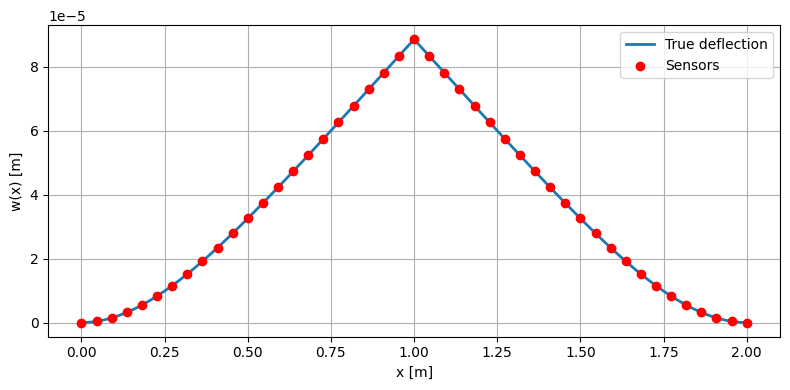

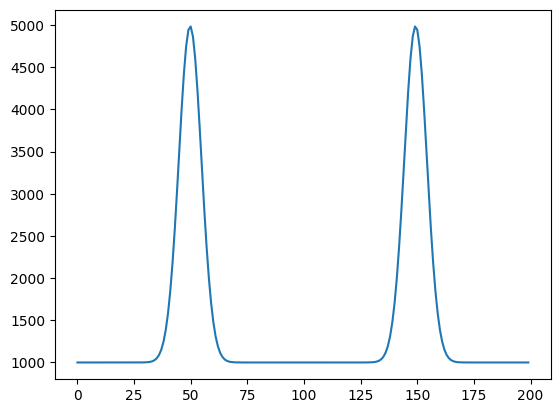

In [558]:
x_full = np.linspace(0, L, 200)
x_sensors = np.linspace(0, L, 45)


if UDL:
  w_true = get_w_udl(x_full)
  w_sensors_clean = get_w_udl(x_sensors)
  q_true = Q * tf.ones([200,1])
  q_max = Q
  
elif ASYM:
  w_true = get_w_asym(x_full)
  w_sensors_clean = get_w_asym(x_sensors)
  q_true = Q * tf.ones([200,1]) + gaussian_prop(tf.convert_to_tensor(x_full.reshape(-1,1), dtype=tf.float32), a, P, sigma=0.01)
  q_max = Q
  
else:
  w_true = get_w_comb_sym(x_full)
  w_sensors_clean = get_w_comb_sym(x_sensors)
  q_true = Q * tf.ones([200,1]) + gaussian_prop(tf.convert_to_tensor(x_full.reshape(-1 , 1), dtype=tf.float32), L / 4, P, sigma=0.05) + gaussian_prop(tf.convert_to_tensor(x_full.reshape(-1, 1), dtype=tf.float32), 3 * L / 4, P, sigma=0.05)
  q_max = P 
  
w_sensors = w_sensors_clean

if Noise:
  np.random.seed(42)
  noise_std = 0.05 * np.max(w_sensors_clean)
  noise = np.random.normal(0, noise_std, size=w_sensors_clean.shape)
  w_sensors += noise

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x_full, w_true, label="True deflection", linewidth=2)

plt.scatter(x_sensors, w_sensors, color='red', label="Sensors", zorder=3)
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(q_true)

#2

In [559]:

x_sensors_norm = (x_sensors / L).reshape(-1, 1)
x_tf = tf.convert_to_tensor(x_full_norm.reshape(-1,1), dtype=tf.float32)
x_sensors_tf = tf.convert_to_tensor(x_sensors_norm, dtype=tf.float32)

w_true = tf.reshape(w_true, (-1, 1))
w_sensors = tf.reshape(w_sensors, (-1, 1))
w_max = tf.reduce_max(w_sensors_clean)
w_sensors_norm = w_sensors / w_max


q_hat_norm = tf.Variable(1.0, dtype=tf.float32, trainable = False)
q_pl_norm = tf.Variable(1.0, dtype=tf.float32)
pred_hinge_loc = 1e-8

q_pl1_norm = tf.Variable(0.0, dtype=tf.float32)
q_pl2_norm = tf.Variable(0.0, dtype=tf.float32)

In [560]:

model = keras.models.Sequential([
        keras.layers.Input(shape=(1,)),
        keras.layers.Dense(128, activation = act, dtype = tf.float32),
        keras.layers.Dense(128, activation = act, dtype = tf.float32),
        keras.layers.Dense(128, activation = act, dtype = tf.float32),
        keras.layers.Dense(2,)  #two outputs: deflection and discontinuity
    ])

lr_scheduler = lambda init_lr: keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=5000,
    decay_rate=0.9,
    )

optimizer = keras.optimizers.Adam(learning_rate = lr_scheduler(init_lr = 1e-3))
optimizer2 = keras.optimizers.Adam(learning_rate = lr_scheduler(init_lr = 1e-3))
optimizer_q_udl = keras.optimizers.Adam(learning_rate = lr_scheduler(init_lr = 1e-3))
optimizer_q_pl = keras.optimizers.Adam(learning_rate = 1e-3)

def get_model_w(inputs):
    return model(inputs)[:, 0:1]

def get_model_b(inputs):
    return tf.sigmoid(model(inputs)[:, 1:2])

In [561]:
def compute_derivatives_bc(x_input):        #continuous derivatives for boundary conditions
    with tf.GradientTape() as tape4:
        tape4.watch(x_input)
        with tf.GradientTape() as tape3:
            tape3.watch(x_input)
            with tf.GradientTape() as tape2:
                tape2.watch(x_input)
                with tf.GradientTape() as tape1:
                    tape1.watch(x_input)
                    w_hat = get_model_w(x_input)
                dw = tape1.gradient(w_hat, x_input)
            d2w = tape2.gradient(dw, x_input)
        d3w = tape3.gradient(d2w, x_input)
    d4w = tape4.gradient(d3w, x_input)
    return w_hat, dw, d2w, d3w, d4w

compute_derivatives = compute_derivatives_bc

In [562]:
beta = tf.constant(0.9, dtype=tf.float32)  # Smoothing factor
w_data = tf.Variable(1.0, dtype=tf.float32)
w_phys = tf.Variable(0.5, dtype=tf.float32)
w_bc = tf.Variable(1.0, dtype=tf.float32)
w_filter = tf.Variable(0.1, dtype=tf.float32)
w_spikes = tf.Variable(0.1, dtype=tf.float32)
w_all = tf.Variable(1.0, dtype=tf.float32)

w_scale = EI * w_max / (L**4 * q_max)

In [563]:
def flatten_grads(grads_list):
    flats = [tf.reshape(g, [-1]) for g in grads_list]
    return tf.concat(flats, axis=0) if flats else tf.constant([], tf.float32)

def update_lra_weights(tape1,
                       physics_loss,
                       data_loss,
                       bc_loss,
                       filter_penalty,
                       update_data=True,
                       update_bcs=True,
                       update_filter=True):
    vars_ = model.trainable_variables
    vars_weights = [v for v in vars_ if ('kernel' in v.name) or ('weight:' in v.name)]
    eps = tf.constant(1e-12, tf.float32)

    # Reference gradient from physics (always computed)
    grad_res = tape1.gradient(physics_loss, vars_weights)
    grad_res = [g if g is not None else tf.zeros_like(v) for g, v in zip(grad_res, vars_weights)]
    grad_res_flat = flatten_grads(grad_res)
    max_grad_res  = tf.reduce_max(tf.abs(grad_res_flat))
    mean_grad_res = tf.reduce_mean(tf.abs(grad_res_flat))
    reference_grad = max_grad_res if Use_Max else mean_grad_res

    # --- DATA ---
    if update_data:
        grad_data = tape1.gradient(data_loss, vars_weights)
        grad_data = [g if g is not None else tf.zeros_like(v) for g, v in zip(grad_data, vars_weights)]
        grad_data_flat = flatten_grads(grad_data)
        mean_grad_data = tf.reduce_mean(tf.abs(grad_data_flat)) + eps
        w_data_hat = reference_grad / mean_grad_data
        if CAP:
            w_data_hat = tf.clip_by_value(w_data_hat, cap_val_min, cap_val_max)
        w_data.assign(w_data * beta + w_data_hat * (1.0 - beta))

    # --- BCs ---
    if update_bcs:
        grad_bcs = tape1.gradient(bc_loss, vars_weights)
        grad_bcs = [g if g is not None else tf.zeros_like(v) for g, v in zip(grad_bcs, vars_weights)]
        grad_bcs_flat = flatten_grads(grad_bcs)
        mean_grad_bcs = tf.reduce_mean(tf.abs(grad_bcs_flat)) + eps
        w_bc_hat = reference_grad / mean_grad_bcs
        if CAP:
            w_bc_hat = tf.clip_by_value(w_bc_hat, cap_val_min, cap_val_max)
        w_bc.assign(w_bc * beta + w_bc_hat * (1.0 - beta))

    # --- FILTER ---
    if update_filter:
        grad_filter = tape1.gradient(filter_penalty, vars_weights)
        grad_filter = [g if g is not None else tf.zeros_like(v) for g, v in zip(grad_filter, vars_weights)]
        grad_filter_flat = flatten_grads(grad_filter)
        mean_grad_filter = tf.reduce_mean(tf.abs(grad_filter_flat)) + eps
        w_filter_hat = reference_grad / mean_grad_filter
        if CAP:
            w_filter_hat = tf.clip_by_value(w_filter_hat, cap_val_min, cap_val_max)
        w_filter.assign(w_filter * beta + w_filter_hat * (1.0 - beta))

    w_phys.assign(1.0)


In [564]:

def piecewise_q_pl(x_norm):
    x_phys = x_norm * L
    q_prop = gaussian_prop(x_phys, L / 4, q_pl1_norm, sigma=0.05) + gaussian_prop(x_phys, 3 * L / 4, q_pl2_norm, sigma=0.05)
    return q_prop

def piecewise_q_udl(x_norm):
    return tf.ones_like(x_norm) * q_hat_norm

def piecewise_q_asym(x_norm):
    x_phys = x_norm * L
    q_prop = tf.ones_like(x_phys) * q_hat_norm + gaussian_prop(x_phys, a, q_pl_norm, sigma=0.01)
    return q_prop

if UDL:
    piecewise_q_normalized = piecewise_q_udl
    load_params = [q_hat_norm]
else:
    piecewise_q_normalized = piecewise_q_pl
    load_params = [q_pl1_norm, q_pl2_norm]
    
if ASYM:
    piecewise_q_normalized = piecewise_q_asym
    load_params = [q_hat_norm, q_pl_norm]

variables = [q_hat_norm, q_pl_norm]
piecewise_q_normalized = piecewise_q_udl

In [565]:
@tf.function
def get_composite_w(x_sensors_tf):   #summing both network output(smooth) and analytically integrated deflection
    x_sensors_phys = x_sensors_tf * L
    Q_pred = q_hat_norm * Q
    P_pred = q_pl_norm * P
    pred_hinge_loc_phys = pred_hinge_loc * L
    
    pred_constants_pl_l, pred_constants_pl_r = get_constants(pred_hinge_loc, P_pred, Q_pred, a, 'Cantilever')[-1], get_constants(L - pred_hinge_loc, P_pred, Q_pred, a, 'Cantilever')[-1]
    x_sensors_phys_left = tf.boolean_mask(x_sensors_phys, x_sensors_phys <= pred_hinge_loc_phys)
    x_sensors_phys_right = tf.boolean_mask(x_sensors_phys, x_sensors_phys > pred_hinge_loc_phys)
    
    w_pred_integrate = tf.concat((w_point_load_new(x_sensors_phys_left, P_pred, a, pred_constants_pl_l, smooth = True), 
                                  w_point_load_new(L - x_sensors_phys_right, P_pred, a, pred_constants_pl_r, smooth = True)
                                  ), axis = 0) / w_max
    w_pred_integrate = tf.reshape(w_pred_integrate, (-1, 1))
    w_pred_smooth = get_model_w(x_sensors_tf)
    
    return w_pred_smooth + w_pred_integrate 

In [566]:
def scale_filter_exp(b_pred, k = 10.0):
    scaled_residual = tf.exp(k * abs(1 - b_pred))
    return tf.reduce_mean(scaled_residual)

def norm_sig(x_norm, k):
    return 2 * (tf.sigmoid(k*x_norm) - 0.5)

def scale_filter_sigmoid(b_pred, k = 10.0):
    scaled_residual = norm_sig(abs(1 - b_pred), k)
    return tf.reduce_mean(scaled_residual)

scale_filter_exp(tf.zeros_like(x_tf))

<tf.Tensor: shape=(), dtype=float32, numpy=22026.466796875>

In [567]:
@tf.function
def train_step_data():
    with tf.GradientTape(persistent=True) as tape:

        w_pred = get_model_w(x_sensors_tf)
        data_loss = tf.reduce_mean(tf.square(w_pred - w_sensors_norm))

        w0, dw0, *_ = compute_derivatives_bc(tf.convert_to_tensor([0.0, 1.0], dtype=tf.float32))
        bc_loss = tf.reduce_mean(tf.square(w0)) + tf.reduce_mean(tf.square(dw0 / L))

        w_data.assign(1.0)
        w_bc.assign(0.1)
        
        differentiable_loss = w_data * data_loss + w_bc * bc_loss

    variables = model.trainable_variables
    grads = tape.gradient(differentiable_loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    del tape

    *_, d4w_norm = compute_derivatives(x_sensors_tf)
    q_hat_tf = piecewise_q_normalized(x_sensors_tf)
    physics_residual = d4w_norm * w_scale - q_hat_tf
    physics_loss = tf.reduce_mean(tf.square(physics_residual))
    filter_penalty = np.nan

    total_loss = sum([data_loss, bc_loss, physics_loss])
    return total_loss, data_loss, bc_loss, physics_loss, filter_penalty, d4w_norm


In [568]:
@tf.function
def train_step_filter(x_colloc, d4w_norm):
    with tf.GradientTape(persistent=True) as tape2:
        with tf.GradientTape(persistent=True) as tape1:
            b_pred = get_model_b(x_colloc)
            q_hat_tf = piecewise_q_normalized(x_colloc)
            physics_residual = d4w_norm * w_scale - q_hat_tf
            filtered_residual = b_pred * physics_residual

            physics_loss = tf.reduce_mean(tf.square(filtered_residual))
            filter_penalty = tf.reduce_mean(tf.square(1 - b_pred))
            #filter_penalty = tf.exp(10 * filter_penalty)
            filter_penalty = scale_filter_sigmoid(b_pred, 5.0)

            tv_b = b_pred[1:] - b_pred[:-1]
            tv_b = tf.reduce_mean(tf.abs(tv_b))

        w_phys.assign(5e-6)
        w_filter.assign(1.0)
        w_spikes.assign(1e-7)
        #update_lra_weights(tape1, physics_loss, tf.constant(0.0), tf.constant(0.0), filter_penalty, update_data=False, update_bcs=False, update_filter=True)
        
        differentiable_loss = w_phys * physics_loss + w_filter * filter_penalty + w_spikes * tv_b

    grads_b = tape2.gradient(differentiable_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads_b, model.trainable_variables))
    del tape2
    
    return w_phys * physics_loss, w_filter * filter_penalty

In [569]:
@tf.function
def train_step_intermediate(x_colloc):
    with tf.GradientTape(persistent=True) as tape:
        
        tape.watch(x_sensors_tf)
        
        w_pred = get_composite_w(x_sensors_tf)
        b_pred = get_model_b(x_colloc)

        data_loss = tf.reduce_mean(tf.square(w_pred - w_sensors_norm))

        w0, dw0, *_ = compute_derivatives_bc(tf.convert_to_tensor([0.0, 1.0], dtype=tf.float32))
        bc_loss = tf.reduce_mean(tf.square(w0)) + tf.reduce_mean(tf.square(dw0 / L))

        *_, d4w_norm = compute_derivatives(x_colloc)
        q_hat_tf = piecewise_q_normalized(x_colloc)
        physics_residual = d4w_norm * w_scale - q_hat_tf
        filtered_residual = b_pred * physics_residual

        physics_loss = tf.reduce_mean(tf.square(filtered_residual))
        spikes_penalty = tf.reduce_mean(tf.square(filtered_residual[1:] - filtered_residual[:-1]))
        
        filter_penalty = scale_filter_sigmoid(b_pred, k = 5.0)

        w_data.assign(1e4)
        w_bc.assign(1e-2)
        w_phys.assign(5e-5)
        w_spikes.assign(1e-2) 
        w_filter.assign(1.0)
        
        differentiable_loss = w_data * data_loss + w_bc * bc_loss + w_phys * physics_loss + w_spikes * spikes_penalty + w_filter * filter_penalty


    grads = tape.gradient(differentiable_loss, model.trainable_variables)
    #grads_udl = tape.gradient(differentiable_loss, [q_hat_norm])
    grads_pl = tape.gradient(differentiable_loss, [q_pl_norm])
    optimizer2.apply_gradients(zip(grads, model.trainable_variables))
    #optimizer_q_udl.apply_gradients(zip(grads_udl, [q_hat_norm]))
    optimizer_q_pl.apply_gradients(zip(grads_pl, [q_pl_norm]))
    del tape
    
    total_loss = sum([data_loss, bc_loss, physics_loss, filter_penalty])
    return total_loss, w_data * data_loss, bc_loss, w_phys * physics_loss, w_filter * filter_penalty

In [570]:
def tf_logit(p, eps=1e-6, dtype=tf.float32):
    p = tf.convert_to_tensor(p, dtype=dtype)
    p = tf.clip_by_value(p, eps, 1.0 - eps)
    return tf.math.log(p) - tf.math.log1p(-p)

def initialise_b(unit_index=1, p0=0.99):
    W, b = model.layers[-1].get_weights()
    W[:, unit_index] = 0.0 
    b[unit_index] = tf_logit(p0) 
    model.layers[-1].set_weights([W, b])
    

In [571]:
Data_only = False

N_DATA = 10000
N_FILTER = 20000
N_INTERM = 40000

history = {"loss": [], "data": [], "phys": [], "bc": [], "filter": []}
history_params = {"q_hat_norm": [], "q_pl_norm": []}
history_weights = {"w_data": [], "w_phys": [], "w_bc": [], "w_filter": [], "w_spikes": []}

In [572]:
for epoch in range(N_DATA + N_FILTER + N_INTERM):#

    if epoch < N_DATA:
      loss, data_l, bc_l, phys_l, filter_l, d4w_norm = train_step_data()
      
    elif epoch == N_DATA:
      print("Freezing everything except the last layer")
      for l in model.variables[:-2]: #everything except weight and bias of last layer
        l.trainable = False
      
      *_ ,d2w_full_norm ,_ ,d4w_full_norm = compute_derivatives(x_tf)
      max_moment_loc = x_tf[tf.argmax(tf.abs(d2w_full_norm)).numpy().item(), 0]
      
      if USE_COLLOC:
        x_colloc = get_collocation_points(x_sensors_tf, max_moment_loc, colloc_width / L, colloc_density)
        tf.print("Collocation points:", x_colloc[:25])
        tf.print(x_colloc[-25:])
      else:
        x_colloc = x_sensors_tf
        
      *_, d4w_norm = compute_derivatives(x_colloc)
      initialise_b()

    elif epoch < N_DATA + N_FILTER:
      phys_l, filter_l = train_step_filter(x_colloc, tf.stop_gradient(d4w_norm))
      data_l, bc_l = tf.cast(history["data"][-1], tf.float32), tf.cast(history["bc"][-1], tf.float32)
      loss = phys_l + filter_l + data_l + bc_l
  
    elif epoch == N_DATA + N_FILTER:
      print("Unfreezing")
      for l in model.variables:
        l.trainable = True   
      
    elif epoch < N_DATA + N_FILTER + N_INTERM:
      pred_hinge_loc = x_tf[tf.argmin(model(x_tf)[:,1])]
      loss, data_l, bc_l, phys_l, filter_l = train_step_intermediate(x_colloc)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d} | "f"Data: {data_l.numpy().item():.6f} | Phys: {phys_l.numpy().item():.6f} | Filter: {filter_l.numpy().item():.6f}  | BC: {bc_l.numpy().item():.6f}| q udl: {q_hat_norm.numpy():.6f}| q pl: {q_pl_norm.numpy():.6f}")
    history["loss"].append(loss.numpy().item())
    history["data"].append(data_l.numpy().item())
    history["phys"].append(phys_l.numpy().item())
    history["bc"].append(bc_l.numpy().item())
    history["filter"].append(filter_l.numpy().item())
    
    '''if ASYM:
      history["q_hat_norm"].append((load_params[0].numpy().item(), load_params[1].numpy().item()))
    else:
      if UDL:
          history["q_hat_norm"].append(load_params[0].numpy().item())
      else:
          history["q_hat_norm"].append((q_pl_norm.numpy().item()))'''
    history_params['q_hat_norm'].append(q_hat_norm.numpy().item())
    history_params['q_pl_norm'].append(q_pl_norm.numpy().item())
    
    history_weights["w_data"].append(w_data.numpy().item())
    history_weights["w_phys"].append(w_phys.numpy().item())
    history_weights["w_bc"].append(w_bc.numpy().item())
    history_weights["w_filter"].append(w_filter.numpy().item())
    history_weights["w_spikes"].append(w_spikes.numpy().item())

Epoch     0 | Data: 0.253723 | Phys: 0.999971 | Filter: nan  | BC: 0.000098| q udl: 1.000000| q pl: 1.000000
Epoch  1000 | Data: 0.000658 | Phys: 562.121887 | Filter: nan  | BC: 0.000157| q udl: 1.000000| q pl: 1.000000
Epoch  2000 | Data: 0.000592 | Phys: 808.795288 | Filter: nan  | BC: 0.000268| q udl: 1.000000| q pl: 1.000000
Epoch  3000 | Data: 0.000511 | Phys: 1257.763672 | Filter: nan  | BC: 0.000309| q udl: 1.000000| q pl: 1.000000
Epoch  4000 | Data: 0.000426 | Phys: 2189.351318 | Filter: nan  | BC: 0.000279| q udl: 1.000000| q pl: 1.000000
Epoch  5000 | Data: 0.000352 | Phys: 3792.188965 | Filter: nan  | BC: 0.000204| q udl: 1.000000| q pl: 1.000000
Epoch  6000 | Data: 0.000269 | Phys: 6968.177246 | Filter: nan  | BC: 0.000162| q udl: 1.000000| q pl: 1.000000
Epoch  7000 | Data: 0.000197 | Phys: 13420.830078 | Filter: nan  | BC: 0.000106| q udl: 1.000000| q pl: 1.000000
Epoch  8000 | Data: 0.000144 | Phys: 24761.964844 | Filter: nan  | BC: 0.000064| q udl: 1.000000| q pl: 1.00

In [573]:
x_tf[tf.argmin(model(x_tf)[:,1])]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.6532663], dtype=float32)>

In [574]:

w, dw, d2w, d3w, d4w = compute_derivatives(x_tf)

b_pred = get_model_b(x_tf)
w_pred = get_composite_w(x_tf) * w_max if (epoch > N_DATA + N_FILTER + 1) else get_model_w(x_tf) * w_max

q_pred = piecewise_q_normalized(x_tf) * q_max

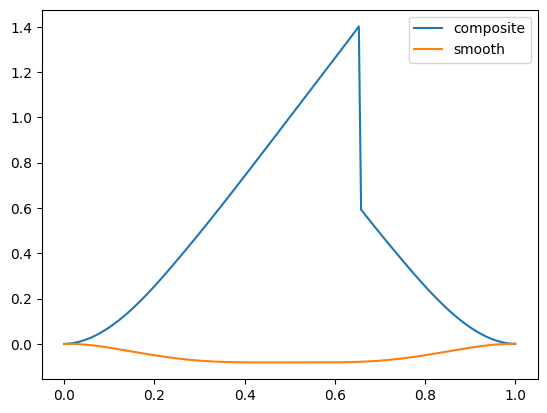

In [575]:
plt.plot(x_tf, get_composite_w(x_tf), label = 'composite')
plt.plot(x_tf, get_model_w(x_tf), label = 'smooth')
plt.legend()

R² score (PINN Model): 0.65345


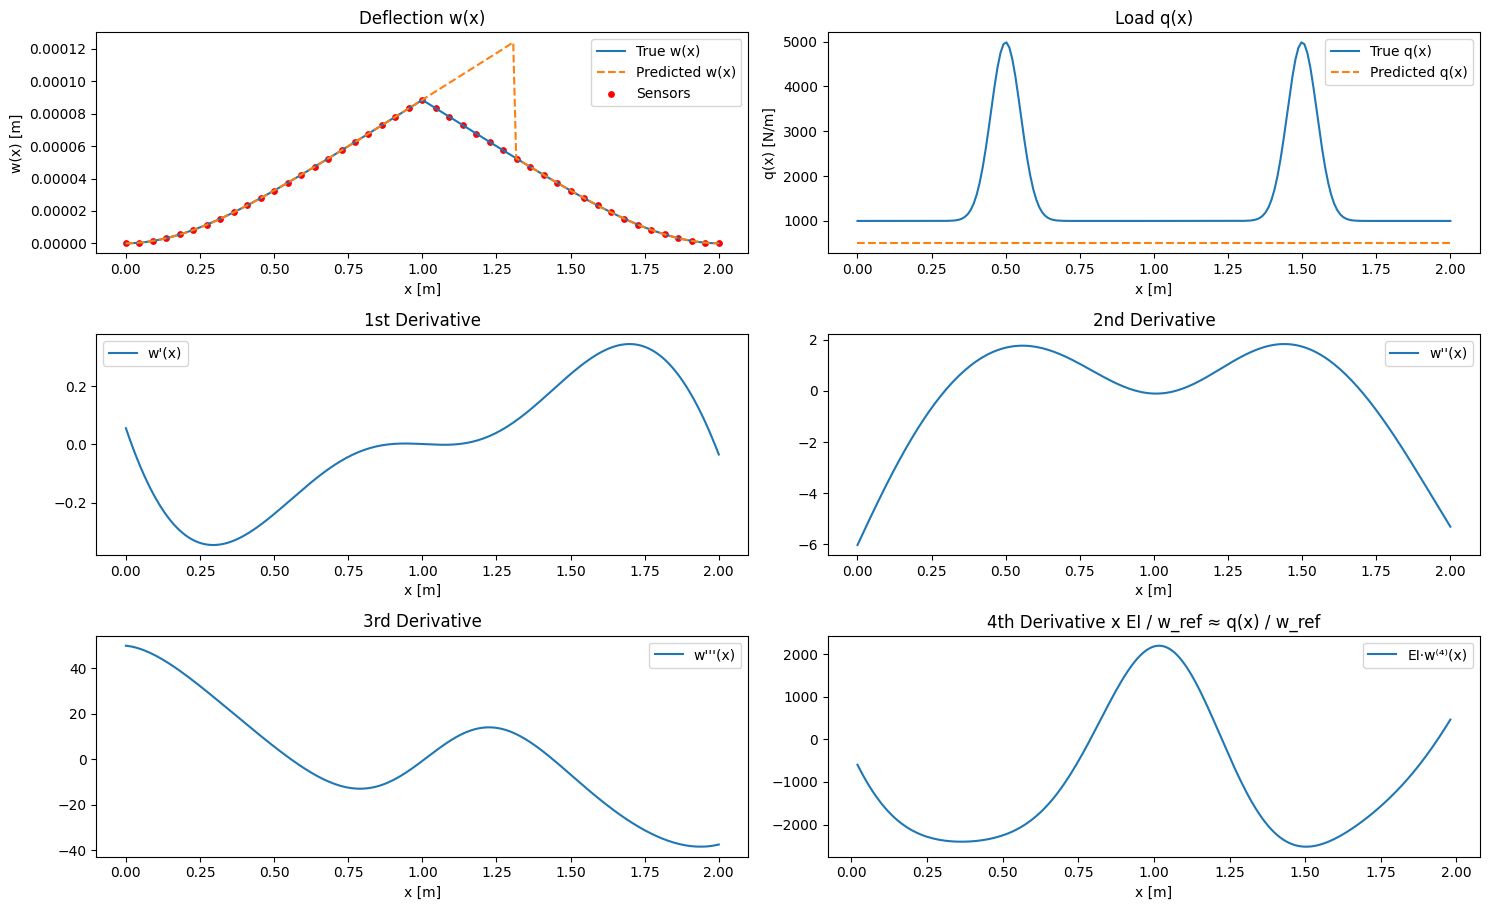

In [576]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 2)

# Define plotting x and evaluate true values
x_plot = x_full  # Dimensional x values

plt.subplot(gs[0, 0])
plt.plot(x_plot, w_true, label="True w(x)")
plt.plot(x_plot, w_pred, '--', label="Predicted w(x)")
plt.scatter(x_sensors, w_sensors, color='red', label="Sensors", s=15)
plt.title("Deflection w(x)")
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.legend()

plt.subplot(gs[0, 1])
plt.plot(x_plot, q_true, label="True q(x)")
plt.plot(x_plot, q_pred, '--', label="Predicted q(x)")
plt.title("Load q(x)")
plt.xlabel("x [m]")
plt.ylabel("q(x) [N/m]")
plt.legend()

plt.subplot(gs[1, 0])
plt.plot(x_plot, dw.numpy(), label="w'(x)")
plt.title("1st Derivative")
plt.xlabel("x [m]")
plt.legend()

plt.subplot(gs[1, 1])
plt.plot(x_plot, d2w.numpy(), label="w''(x)")
plt.title("2nd Derivative")
plt.xlabel("x [m]")
plt.legend()

plt.subplot(gs[2, 0])
plt.plot(x_plot, d3w.numpy(), label="w'''(x)")
plt.title("3rd Derivative")
plt.xlabel("x [m]")
plt.legend()

# Ensure w_ref is defined for correct scaling
w_ref = L**4 / EI

plt.subplot(gs[2, 1])
plt.plot(x_plot[2:-2], d4w[2:-2] * w_max / w_ref, label="EI·w⁽⁴⁾(x)")
#plt.plot(x_plot, q_pred , '--', label="Predicted q(x) / w_ref")
plt.title("4th Derivative x EI / w_ref ≈ q(x) / w_ref")
plt.xlabel("x [m]")
plt.legend()

from sklearn.metrics import r2_score
r2_data = r2_score(w_true, w_pred)
print(f"R² score (PINN Model): {r2_data:.5f}")
#plt.suptitle(f"Learned q(x): a={a_dim:.4f}, b={b_dim:.4f}, c={c_dim:.4f}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# Compute R²


In [577]:
*_, d4w_cont = compute_derivatives_bc(x_tf)
d4w_cont.shape

TensorShape([200, 1])

tf.Tensor([0.6532663], shape=(1,), dtype=float32)


Text(0.5, 1.0, 'Physics Residual Squared')

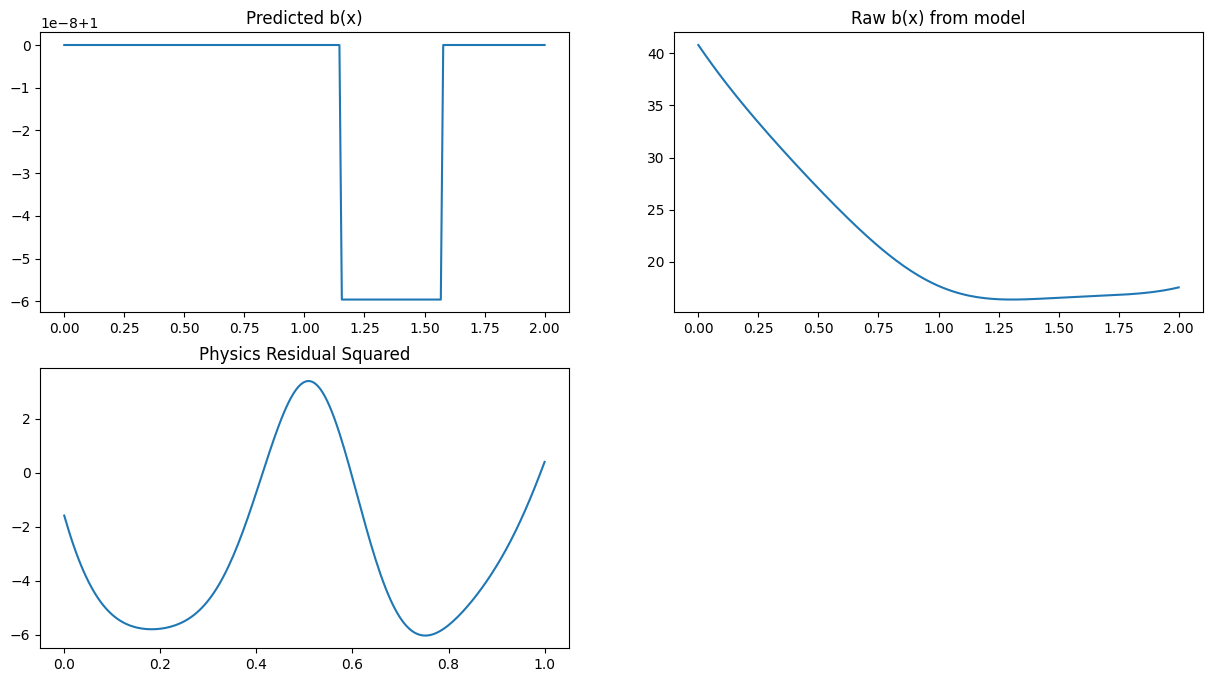

In [578]:
plt.figure(figsize=(15, 8))
plt.subplot(221)
plt.plot(x_full, b_pred)
plt.title("Predicted b(x)")

plt.subplot(222)
b_raw = model(x_tf)[:, 1]
plt.plot(x_full, (b_raw))
plt.title("Raw b(x) from model")
print(x_tf[tf.argmin(b_raw)])

plt.subplot(223)
plt.plot(x_tf,(b_pred * (d4w * w_scale - q_pred / q_max)))

plt.title("Physics Residual Squared")

1.0

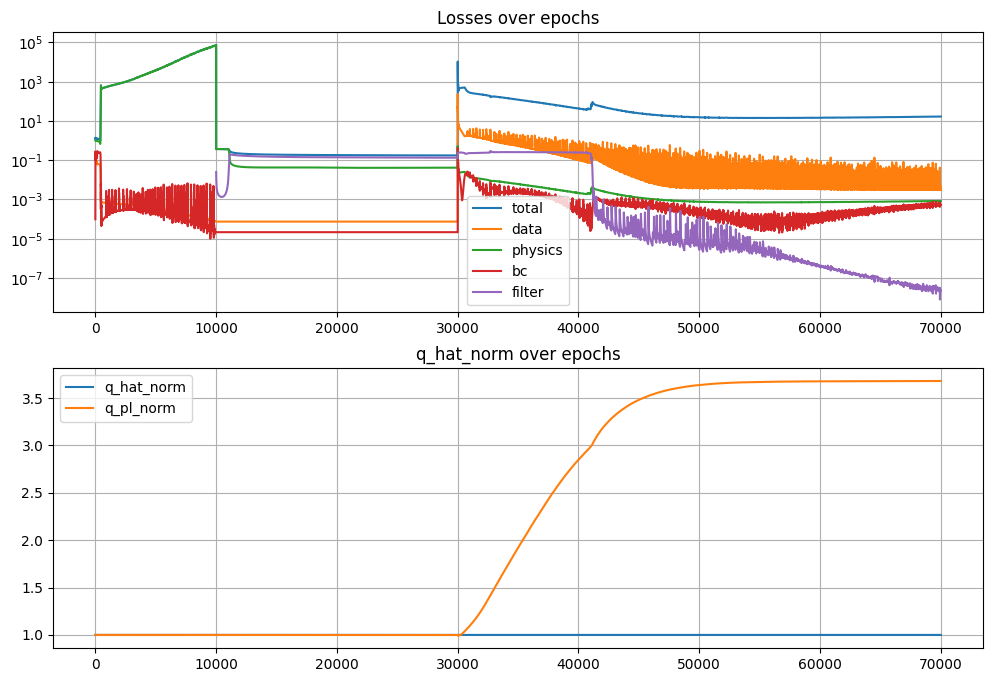

In [579]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(history['loss'], label = 'total')
plt.plot(history['data'], label = 'data')
plt.plot(history['phys'], label = 'physics')
plt.plot(history['bc'], label = 'bc')
plt.plot(history['filter'], label = 'filter')
plt.legend()
plt.grid(True)
plt.title("Losses over epochs")
plt.yscale('log')

plt.subplot(212)

'''if ASYM:
    q_hat_array = np.array(history['q_hat_norm'])
    plt.plot(q_hat_array[:, 0], label='q_hat_norm')
    plt.plot(q_hat_array[:, 1], label='q_pl_norm')
else:
    if UDL:
        plt.plot(history['q_hat_norm'], label='q_hat_norm')
    else:
        q_hat_array = np.array(history['q_hat_norm'])
        plt.plot(q_hat_array[:, 0], label='q_pl1_norm')
        plt.plot(q_hat_array[:, 1], label='q_pl2_norm')'''
        
plt.plot(history_params['q_hat_norm'], label='q_hat_norm')
plt.plot(history_params['q_pl_norm'], label='q_pl_norm')
plt.legend()
plt.grid(True)
plt.title("q_hat_norm over epochs")
q_hat_norm.numpy()

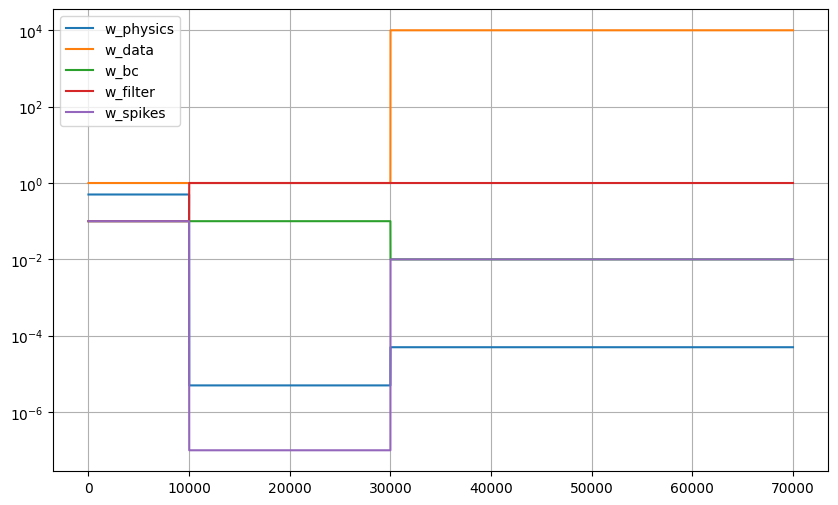

In [580]:
plt.figure(figsize=(10, 6))

plt.plot(history_weights['w_phys'], label = 'w_physics')
plt.plot(history_weights['w_data'], label = 'w_data')
plt.plot(history_weights['w_bc'], label = 'w_bc')
plt.plot(history_weights['w_filter'], label = 'w_filter')
plt.plot(history_weights['w_spikes'], label = 'w_spikes')

plt.grid(True)
plt.yscale('log')
plt.legend()

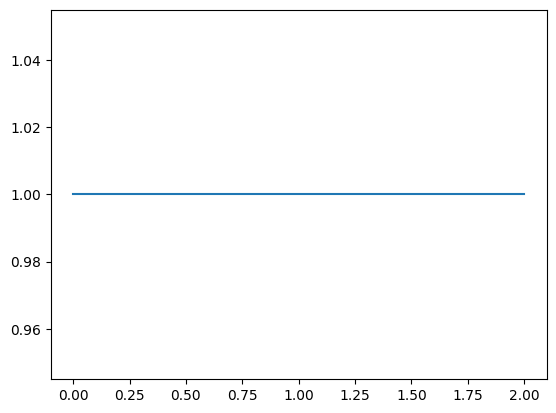

In [581]:
plt.plot(x_full, q_pred / q_max)